Github suggestion how to run TFacTomo (this is exactly how it is written):

# Python packages to be run:

[python 3.8.12]
[numpy 1.21.5]
[pytorch 1.10.2]
[tensorly 0.6.0]

# R packages to be run

[R 4.2.2]
[shiny 1.7.1]
[reticulate 1.25]
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Reproducing Results on Mouse Olfactory Mucosa

Reconstruction

You can skip this step if you just want to use the tensor models already in our repository.

They are stored in vis_OM/tensor_model/*.npy

1) Run the tensor model on 1D spatial gene expression data (tomo-seq), protein-protein interaction (PPI) network and spatial chain graphs, and 3D binary mask (where 0s indicate no tissue covered).


# Load required packages
import torch
import numpy as np
import tensorly as tl
from TFacTomo import reconstruct
# Set tensorly backend as pytorch
tl.set_backend('pytorch')

# Load 1D gene expression data along different spatial axes
X_x = np.load("data/mouse_olfactory_mucosa/normalized_fitted_lml_data.npy"); X_x = torch.from_numpy(X_x).to(torch.float)
X_y = np.load("data/mouse_olfactory_mucosa/normalized_fitted_dv_data.npy"); X_y = torch.from_numpy(X_y).to(torch.float)
X_z = np.load("data/mouse_olfactory_mucosa/normalized_fitted_ap_data.npy"); X_z = torch.from_numpy(X_z).to(torch.float)
# Load knowledge graphs along gene and spatial axes
W_g = np.load("data/mouse_olfactory_mucosa/mus_musculus_ppi_adjacency_matrix.npy"); W_g = torch.from_numpy(W_g).to(torch.float)
W_x = np.load("data/mouse_olfactory_mucosa/W_x.npy"); W_x = torch.from_numpy(W_x).to(torch.float)
W_y = np.load("data/mouse_olfactory_mucosa/W_y.npy"); W_y = torch.from_numpy(W_y).to(torch.float)
W_z = np.load("data/mouse_olfactory_mucosa/W_z.npy"); W_z = torch.from_numpy(W_z).to(torch.float)
# Load the 3D binary mask 
M = np.load("data/mouse_olfactory_mucosa/mouse_olfactory_mucosa_mask.npy"); M = torch.from_numpy(M).to(torch.float)

# Reconstruct 4D expression tensor by setting hyperparameters rank=500, alpha=1e2, beta=1, and lambda=1, where lambda is a
# hyperparameter controlling l2 regularization on tensor factors, we kept using 1 in our experiments reported in the paper.
A = reconstruct([X_x, X_y, X_z], 1-M, [W_g, W_x, W_y, W_z], 500, 1e2, 1, 1, stop_crit=1e-4, reduction="sum", max_epoch=1000)
T_hat = tl.cp_tensor.cp_to_tensor((None, A))
torch.save(A, "results/mouse_olfactory_mucosa_CPD_factors.pt")


2) Save CANDECOMP/PARAFAC (CP) decomposition factors (A_g, A_x, A_y, A_z) for visualization.

A = torch.load("results/mouse_olfactory_mucosa_CPD_factors.pt")
np.save("A_g.npy", A[0])
np.save("A_x.npy", A[1])
np.save("A_y.npy", A[2])
np.save("A_z.npy", A[3])


3) Visualization

# Load required packages
library(shiny)
library(reticulate)
source("vis_OM/server.R")
source("vis_OM/ui.R")

# Load in environment variables using OM_TFacTomo.RData
load("vis_OM/OM_TFacTomo.RData")

# Load in the gene symbols and CP factors (A_g, A_x, A_y, A_z)
np <- import("numpy") # using the reticulate package to load Python objects into R
genes <- np$loadtxt("genes.txt") 
A_g <- np$load("vis_OM/tensor_model/A_g.npy")
A_x <- np$load("vis_OM/tensor_model/A_x.npy")
A_y <- np$load("vis_OM/tensor_model/A_y.npy")
A_z <- np$load("vis_OM/tensor_model/A_z.npy")

# Launch R shiny App to see the 3D expression reconstruction interactively (Under construction ...)
shinyApp(ui, server)

Install necessary packages directly in the notebook, as it cannot be imported otherwise. Comment out if reinstalling is needed.

In [3]:
# directly importing the packages to the notboke, because other approaches do not work..

"""import sys
print("Installing pandas via", sys.executable)
!{sys.executable} -m pip install pandas

print("Installing pandas via", sys.executable)
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install seaborn"""

'import sys\nprint("Installing pandas via", sys.executable)\n!{sys.executable} -m pip install pandas\n\nprint("Installing pandas via", sys.executable)\n!{sys.executable} -m pip install matplotlib\n!{sys.executable} -m pip install seaborn'

In [6]:
# verify which python my notebook uses

import sys, os
print("sys.executable →", sys.executable)
print("CONDA_DEFAULT_ENV →", os.environ.get("CONDA_DEFAULT_ENV"))
print("sys.path[:3] →", sys.path[:3])


sys.executable → /Users/kimjob/opt/anaconda3/envs/tfactomo/bin/python
CONDA_DEFAULT_ENV → tfactomo
sys.path[:3] → ['/Users/kimjob/PhD/PhD/Scripts/Main Project', '/Users/kimjob/opt/anaconda3/envs/tfactomo/lib/python38.zip', '/Users/kimjob/opt/anaconda3/envs/tfactomo/lib/python3.8']


Reconstruction 

In [3]:
# you need to be in the CTFacTomo folder such that you can run the TFacTomo package

import sys
sys.path.append('/Users/kimjob/PhD/PhD/Scripts/Main Project/CTFacTomo')  
from TFacTomo import reconstruct


Reconstruct function: The function where TFacTomo reconstructs the 3D spatial gene expression from the 1D input data. 

In [574]:
import os
import gc
import torch
import numpy as np
import tensorly as tl
from functools import reduce

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tl.set_backend('pytorch')

''' Collapsing function --> This is the Kathri-Rhao: Each mode-1 is summed over its rows'''
# Auxiliary function to collapse all components
def collapse(A):
    
    a = [A[i].sum(axis=0).unsqueeze(0) for i in range(len(A))]
    
    return a


''' Measuring relative changes between old factors and updated factors '''
# Compute residuals among old and new components
def compute_res(A, A_hat):
    res_num = 0
    res_denom = 0
    for i in range(len(A)):
        res_num += torch.sum((A[i] - A_hat[i]) ** 2) # checks items of factor matrix, say A_x has 54 items --> sums over all entries and checks if the sum matches the updated one
        res_denom += torch.sum(A_hat[i] ** 2)
    return float(torch.sqrt(res_num / res_denom))

''' Core loop of TFacTomo --> reconstruction part of the 3d spatial gene expression:
X = modes 3x spatial + one gene mode

'''
# Define the model
def reconstruct_tfactomo(X, M, W, rank, alpha, beta, l, stop_crit=1e-3, 
         max_epoch=501, reduction='sum', verbose=True, freq=10):
    
    n = np.array([W_.shape[0] for W_ in W]) # size of mode (x,y,z,g)
    n_modes = len(n)
    eps = 1e-10

    ''' Graph normalization: graph laplacian '''
    
    # Normalize adjacency matrix
    D_ = []
    W_ = W.copy()
    for i in range(n_modes):                                                 # 4 modes
        W_[i] = W_[i] - torch.diag(torch.diag(W_[i]))                        # len(W_[i]) = values from each mode --> 54, 56 ...
        d = torch.sum(W_[i], 0)
        nz_index = torch.where(d != 0)
        d[nz_index] = d[nz_index] ** (-0.5)
        d = d.expand([len(d), -1])
        W_[i] = d.T * W_[i] * d
        D_.append(torch.diag(torch.sum(W_[i], 0)).to_sparse().type(torch.float32))
        W_[i] = W_[i].to_sparse().type(torch.float32)
    
    # Initialization
    A = []
    ATA = []; aaT = []
    WA = []; DA = []
    ATWA = []; ATDA = []
    
    for i in range(n_modes):
        A.append(torch.rand(n[i], rank))
        ATA.append(A[i].T @ A[i])
        aaT.append(torch.outer(A[i].sum(axis=0), A[i].sum(axis=0)))
        WA.append(W_[i] @ A[i])
        DA.append(D_[i] @ A[i])
        ATWA.append(A[i].T @ WA[i])
        ATDA.append(A[i].T @ DA[i])
    
    # Convert expression matrix to tensor
    X_ = X.copy()
    X_ = [None] + X_
    for i in range(1, n_modes):
        X_[i] = X_[i][(..., ) + (None, )*2]
        X_[i] = X_[i].swapaxes(1, i)
    
    for epoch in range(1, max_epoch):
        
        A_hat = A.copy()
        
        # Update gene component and spatial components in x, y ,z order
        for i in range(n_modes):
            
            a = collapse(A)
            
            # gene component
            if i == 0:
                
                J1n = 0
                for j in range(1, n_modes):
                    a_ = a.copy()
                    a_[0] = A[0]; a_[j] = A[j]
                    theta = tl.cp_tensor.unfolding_dot_khatri_rao(X_[j], (None, a_), 0)
                    if reduction == 'mean':
                        J1n = J1n + theta / np.prod(np.delete(n, [0, j]))
                    else: # sum
                        J1n = J1n + theta 
                J1p = 0
                for j in range(1, n_modes):
                    phi = aaT.copy()
                    phi[j] = ATA[j]; del phi[0]
                    if reduction == 'mean':
                        J1p = J1p + A[0] @ reduce(torch.mul, phi) / (np.prod(np.delete(n, [0, j])) ** 2)
                    else: # sum
                        J1p = J1p + A[0] @ reduce(torch.mul, phi)
        
                A_ = A.copy()
                A_[0] = a[0]
                J2p = tl.cp_tensor.unfolding_dot_khatri_rao(tl.cp_tensor.cp_to_tensor((None, A_), M),
                                                            (None, A_), 0)
                if reduction == 'mean':
                    J2p = J2p.repeat(n[0], 1) / (n[0] ** 2)
                else:
                    J2p = J2p.repeat(n[0], 1)
            
            # spatial component
            else:
                
                J1n = 0
                for j in range(1, n_modes):
                    a_ = a.copy()
                    a_[0] = A[0]; a_[j] = A[j]
                    theta = tl.cp_tensor.unfolding_dot_khatri_rao(X_[j], (None, a_), i)
                    if j != i:
                        theta = theta.repeat(n[i], 1)
                    if reduction == 'mean':
                        J1n = J1n + theta / np.prod(np.delete(n, [0, j]))
                    else: # sum
                        J1n = J1n + theta
                
                J1p = 0
                phi = aaT.copy()
                phi[0] = ATA[0]; del phi[i]
                if reduction == 'mean':
                    J1p = J1p + A[i] @ reduce(torch.mul, phi) / (np.prod(np.delete(n, [0, i])) ** 2)
                else: # sum
                    J1p = J1p + A[i] @ reduce(torch.mul, phi)

                phi_sum = 0
                for j in range(1, n_modes):
                    if j != i:
                        phi = aaT.copy()
                        phi[0] = ATA[0]; phi[j] = ATA[j]; del phi[i]
                        if reduction == 'mean':
                            phi_sum = phi_sum + reduce(torch.mul, phi) / (np.prod(np.delete(n, [0, j])) ** 2)
                        else: # sum
                            phi_sum = phi_sum + reduce(torch.mul, phi)
                        
                phi_sum = A[i].sum(axis=0).unsqueeze(0) @ phi_sum
                phi_sum = phi_sum.repeat(n[i], 1)
                J1p = J1p + phi_sum
                
                
                A_ = A.copy()
                A_[0] = a[0]
                J2p = tl.cp_tensor.unfolding_dot_khatri_rao(tl.cp_tensor.cp_to_tensor((None, A_), M),
                                                            (None, A_), i)
                
                if reduction == 'mean':
                    J2p = J2p / (n[0] ** 2)
            
            
            ATA_ = ATA.copy()
            del ATA_[i]
            ATA_prod = reduce(torch.mul, ATA_)
            psi_sum = 0
            for j in range(n_modes):
                psi = ATA.copy()
                psi[j] = ATWA[j]
                del psi[i]
                psi_sum = psi_sum + reduce(torch.mul, psi)
            
            J3n =  WA[i] @ ATA_prod + A[i] @ psi_sum
            
            
            ATA_ = ATA.copy()
            del ATA_[i]
            ATA_prod = reduce(torch.mul, ATA_)
            psi_sum = 0
            for j in range(n_modes):
                psi = ATA.copy()
                psi[j] = ATDA[j]
                del psi[i]
                psi_sum = psi_sum + reduce(torch.mul, psi)
            
            J3p =  DA[i] @ ATA_prod + A[i] @ psi_sum
                
            J4p = A[i]
            
            num =  J1n + beta * J3n
            denom = J1p + alpha * J2p + beta * J3p + l * J4p
            A[i] = A[i] * (num/(denom+eps))
            
            ATA[i] = A[i].T @ A[i]
            aaT[i] = torch.outer(A[i].sum(axis=0), A[i].sum(axis=0))
            WA[i] = W_[i] @ A[i]
            DA[i] = D_[i] @ A[i]
            ATWA[i] = A[i].T @ WA[i]
            ATDA[i] = A[i].T @ DA[i]
            
        res = compute_res(A, A_hat)
        if verbose and epoch % freq == 0:
            print(f'Training epoch: {epoch:02d}, Residual: {res:.4f}')
        
        # Terminate the training either when the stopping criterion is met or the maximum number of iterations is reached
        if res < stop_crit:
            break        
    
    return A

IPF


Load data from TFacTomo authors - run TFacTomo like this

In [210]:

import os
import gc
import torch
import numpy as np
import tensorly as tl
from functools import reduce
from TFacTomo import reconstruct
import pandas as pd
from tensorly.cp_tensor import cp_to_tensor


# Set tensorly backend as pytorch
tl.set_backend('pytorch')

''' 
original order of authors

X_x = LML
X_y = DV
X_z = AP
'''

# Load 1D gene expression data along different spatial axes 
X_x_lml = np.load("/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/TFacTomo_OM_data/data/mouse_olfactory_mucosa/normalized_fitted_lml_data.npy"); X_x_lml = torch.from_numpy(X_x_lml).to(torch.float)
X_y_dv = np.load("/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/TFacTomo_OM_data/data/mouse_olfactory_mucosa/normalized_fitted_dv_data.npy"); X_y_dv = torch.from_numpy(X_y_dv).to(torch.float)
X_z_ap = np.load("/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/TFacTomo_OM_data/data/mouse_olfactory_mucosa/normalized_fitted_ap_data.npy"); X_z_ap = torch.from_numpy(X_z_ap).to(torch.float)

genes = np.loadtxt("/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/TFacTomo_OM_data/data/mouse_olfactory_mucosa/genes.txt", dtype=str)
# Load knowledge graphs along gene and spatial axes
W_g = np.load("/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/TFacTomo_OM_data/data/mouse_olfactory_mucosa/mus_musculus_ppi_adjacency_matrix.npy"); W_g = torch.from_numpy(W_g).to(torch.float)
W_x = np.load("/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/TFacTomo_OM_data/data/mouse_olfactory_mucosa/W_x.npy"); W_x = torch.from_numpy(W_x).to(torch.float)
W_y = np.load("/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/TFacTomo_OM_data/data/mouse_olfactory_mucosa/W_y.npy"); W_y = torch.from_numpy(W_y).to(torch.float)
W_z = np.load("/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/TFacTomo_OM_data/data/mouse_olfactory_mucosa/W_z.npy"); W_z = torch.from_numpy(W_z).to(torch.float)


# Load the 3D binary mask 
M = np.load("/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/TFacTomo_OM_data/data/mouse_olfactory_mucosa/mouse_olfactory_mucosa_mask.npy"); M = torch.from_numpy(M).to(torch.float)


In [336]:
# modifying the data to dataframe such that the data can be compared with mayras data:

X_x_np = X_x_lml.cpu().numpy() 
X_y_np = X_y_dv.cpu().numpy()
X_z_np = X_z_ap.cpu().numpy()

cols_x = [f"V{i+1}" for i in range(X_x_np.shape[1])] # 1 not 0 because shape is (9254, 56)
cols_y = [f"V{i+1}" for i in range(X_y_np.shape[1])]
cols_z = [f'V{i+1}' for i in range(X_z_np.shape[1])]

X_x_dataframe = pd.DataFrame(X_x_np, index=genes, columns=cols_x)
X_y_dataframe = pd.DataFrame(X_y_np, index=genes, columns=cols_y)
X_z_dataframe = pd.DataFrame(X_z_np, index=genes, columns=cols_z)



In [587]:
X_x_dataframe

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56
0610010F05Rik,3.557514,6.177112,10.129560,13.804648,16.850567,19.065969,21.364780,23.883028,25.727057,28.859741,...,28.859741,25.727057,23.883028,21.364780,19.065969,16.850567,13.804648,10.129560,6.177112,3.557514
0610010K14Rik,0.291829,0.523297,0.882034,1.229500,1.527342,1.749667,1.974655,2.210545,2.350892,2.566002,...,2.566002,2.350892,2.210545,1.974655,1.749667,1.527342,1.229500,0.882034,0.523297,0.291829
1110004F10Rik,18.506840,32.963711,55.341251,77.041840,95.828339,110.195381,125.141754,141.334717,152.883667,171.142685,...,171.142685,152.883667,141.334717,125.141754,110.195381,95.828339,77.041840,55.341251,32.963711,18.506840
1110008P14Rik,3.136951,5.727728,9.825440,13.931841,17.595749,20.482800,23.477108,26.680161,28.893997,32.221245,...,32.221245,28.893997,26.680161,23.477108,20.482800,17.595749,13.931841,9.825440,5.727728,3.136951
1700001K19Rik,0.089016,0.157059,0.261325,0.360656,0.444772,0.507020,0.570584,0.638482,0.690168,0.778396,...,0.778396,0.690168,0.638482,0.570584,0.507020,0.444772,0.360656,0.261325,0.157059,0.089016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Olfr309,0.379594,1.642992,4.293971,7.981828,12.240688,16.512651,21.251282,26.502243,30.961081,36.741520,...,36.741520,30.961081,26.502243,21.251282,16.512651,12.240688,7.981828,4.293971,1.642992,0.379594
Moxd2,4.952329,12.792233,27.819990,47.047779,68.154915,88.548233,110.996490,135.845535,157.928818,188.531372,...,188.531372,157.928818,135.845535,110.996490,88.548233,68.154915,47.047779,27.819990,12.792233,4.952329
Lcn4,5.893780,4.748703,0.792942,0.000000,0.000000,0.000000,0.000000,9.867999,39.014744,88.383301,...,88.383301,39.014744,9.867999,0.000000,0.000000,0.000000,0.000000,0.792942,4.748703,5.893780
Gucy1b2,1.323378,2.392239,4.050905,5.653088,7.004929,7.973733,8.905092,9.820085,10.230769,10.867538,...,10.867538,10.230769,9.820085,8.905092,7.973733,7.004929,5.653088,4.050905,2.392239,1.323378


In [58]:
# verify which python my notebook uses

import sys, os
print("sys.executable →", sys.executable)
print("CONDA_DEFAULT_ENV →", os.environ.get("CONDA_DEFAULT_ENV"))
print("sys.path[:3] →", sys.path[:3])


sys.executable → /Users/kimjob/opt/anaconda3/envs/tfactomo/bin/python
CONDA_DEFAULT_ENV → tfactomo
sys.path[:3] → ['/Users/kimjob/PhD/PhD/Scripts/Main Project', '/Users/kimjob/opt/anaconda3/envs/tfactomo/lib/python38.zip', '/Users/kimjob/opt/anaconda3/envs/tfactomo/lib/python3.8']


Select only the genes from mayras data where also the PPI network is available. So 9254 genes area avaialble.

In [61]:
# Mayras data as input


DV_axis_norm = pd.read_csv('/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/Mayras_data/normalized_DATA/DV_RPMnormExpression1D.csv', index_col=0)
PA_axis_norm = pd.read_csv('/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/Mayras_data/normalized_DATA/AP_RPMnormExpression1D.csv', index_col=0)
LML_axis_norm = pd.read_csv('/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/Mayras_data/normalized_DATA/LML_RPMnormExpression1D.csv', index_col=0)

DV_axis_fitted = pd.read_csv('/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/Mayras_data/DATA/fitted_data/fittedDV.csv')
PA_axis_fitted = pd.read_csv('/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/Mayras_data/DATA/fitted_data/fittedAP.csv')
LML_axis_fitted = pd.read_csv('/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/Mayras_data/DATA/fitted_data/fittedLML.csv')

# loading volume of the slices along each axis

volume_PA = pd.read_csv('/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/Mayras_data/ScialdoneLab-Spatial-Transcriptomics-e365762-2/Shiny3DMOEapp1.6/sliceVolAP.csv')
volume_DV = pd.read_csv('/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/Mayras_data/ScialdoneLab-Spatial-Transcriptomics-e365762-2/Shiny3DMOEapp1.6/sliceVolDV.csv')
volume_LML = pd.read_csv('/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/Mayras_data/ScialdoneLab-Spatial-Transcriptomics-e365762-2/Shiny3DMOEapp1.6/sliceVolLML.csv')




DV_axis_fitted.insert(0, 'gene_name', DV_axis_norm.index.to_list())
PA_axis_fitted.insert(0, 'gene_name', PA_axis_norm.index.to_list())
LML_axis_fitted.insert(0, 'gene_name', LML_axis_norm.index.to_list())

# rename gene column properly
DV_axis_fitted = DV_axis_fitted.set_index('gene_name')
PA_axis_fitted = PA_axis_fitted.set_index('gene_name')
LML_axis_fitted = LML_axis_fitted.set_index('gene_name')


"""# keep only rows whose index is in your `genes` list
DV_axis_sub = DV_axis_fitted.loc[DV_axis_fitted.index.isin(genes)]
LML_axis_sub = LML_axis_fitted.loc[LML_axis_fitted.index.isin(genes)]
AP_axis_sub = PA_axis_fitted.loc[PA_axis_fitted.index.isin(genes)]
"""


'# keep only rows whose index is in your `genes` list\nDV_axis_sub = DV_axis_fitted.loc[DV_axis_fitted.index.isin(genes)]\nLML_axis_sub = LML_axis_fitted.loc[LML_axis_fitted.index.isin(genes)]\nAP_axis_sub = PA_axis_fitted.loc[PA_axis_fitted.index.isin(genes)]\n'

In [62]:
# transform volume to the right shape 

volume_DV = volume_DV.iloc[:, 0]
volume_PA = volume_PA.iloc[:, 0]
volume_LML = volume_LML.iloc[:, 0]

In [579]:
volume_PA

0      680
1      680
2      680
3      680
4      680
5      676
6      676
7      676
8      676
9      676
10     712
11     712
12     712
13     712
14     712
15     706
16     706
17     706
18     706
19     706
20    1234
21    1234
22    1234
23    1234
24    1234
25    1382
26    1382
27    1382
28    1382
29    1382
30    1336
31    1336
32    1336
33    1336
34    1336
35    1452
36    1452
37    1452
38    1452
39    1452
40    1646
41    1646
42    1646
43    1646
44    1646
45    2142
46    2142
47    2142
48    2142
49    2142
50    2008
51    2008
52    2008
53    2008
54    2008
55    1508
56    1508
57    1508
58    1508
59    1508
Name: x, dtype: int64

In [ ]:
''' 
dataframes are from the input data of the authors:

X_x = LML
X_y = DV
X_z = AP

X_x_dataframe = LML
X_y_dataframe = DV
X_z_dataframe = AP

'''

common_genes = sorted(set(genes) & set(DV_axis_fitted.index) & set(LML_axis_fitted.index) & set(PA_axis_fitted.index)) # define genes that are common for both dataframes


DV_axis_fitted_ordered = DV_axis_fitted.loc[common_genes].reindex(genes)
LML_axis_fitted_ordered = LML_axis_fitted.loc[common_genes].reindex(genes)
AP_axis_fitted_ordered  = PA_axis_fitted.loc[common_genes].reindex(genes)

target_DV  = DV_axis_fitted_ordered.to_numpy(dtype=np.float64)
target_LML = LML_axis_fitted_ordered.to_numpy(dtype=np.float64)
target_AP  = AP_axis_fitted_ordered.to_numpy(dtype=np.float64)

# you need to change the dataframe to a numpy array

target_DV = np.asarray(target_DV, dtype=np.float64)* volume_DV.values / volume_DV.sum()
target_AP = np.asarray(target_AP, dtype=np.float64)* volume_PA.values / volume_PA.sum()
target_LML = np.asarray(target_LML, dtype=np.float64)* volume_LML.values / volume_LML.sum()


X_dv  = torch.from_numpy(target_DV).float()#(1, 54) DV
X_lml = torch.from_numpy(target_LML).float()#(1, 56) LML 
X_ap  = torch.from_numpy(target_AP).float()#(1, 60) AP






In [545]:
mask3d.sum()

77410.0

In [550]:
volume_PA.values


array([ 680,  680,  680,  680,  680,  676,  676,  676,  676,  676,  712,
        712,  712,  712,  712,  706,  706,  706,  706,  706, 1234, 1234,
       1234, 1234, 1234, 1382, 1382, 1382, 1382, 1382, 1336, 1336, 1336,
       1336, 1336, 1452, 1452, 1452, 1452, 1452, 1646, 1646, 1646, 1646,
       1646, 2142, 2142, 2142, 2142, 2142, 2008, 2008, 2008, 2008, 2008,
       1508, 1508, 1508, 1508, 1508])

In [316]:
print(DV_axis_fitted_ordered.shape)
print(target_DV.shape)

(9254, 54)
(9254, 54)


In [51]:
print('X_lml:',X_lml.shape)
print('X_dv:',X_dv.shape)
print('X_ap:',X_ap.shape)

# double check which datasets have which shapes

print('Approch 1:')
print("X_x shape:", X_x_lml.shape)
print("X_y shape:", X_y_dv.shape)
print("X_z shape:", X_z_ap.shape)
print('Approch 2:')
print("X_lml shape:", X_lml.shape)
print("X_dv shape:", X_dv.shape)
print("X_ap shape:", X_ap.shape)
print('PPI Network:')
print("M shape:", M.shape)
print("W_x shape:", W_x.shape)
print("W_y shape:", W_y.shape)
print("W_z shape:", W_z.shape)
print("W_g shape:", W_g.shape)

X_lml: torch.Size([9254, 56])
X_dv: torch.Size([9254, 54])
X_ap: torch.Size([9254, 60])
Approch 1:
X_x shape: torch.Size([9254, 56])
X_y shape: torch.Size([9254, 54])
X_z shape: torch.Size([9254, 60])
Approch 2:
X_lml shape: torch.Size([9254, 56])
X_dv shape: torch.Size([9254, 54])
X_ap shape: torch.Size([9254, 60])
PPI Network:
M shape: torch.Size([54, 56, 60])
W_x shape: torch.Size([54, 54])
W_y shape: torch.Size([56, 56])
W_z shape: torch.Size([60, 60])
W_g shape: torch.Size([9254, 9254])


Check if the gene index is the same

Visualize TFacTomo results


Run the TFacTomo app:

things to fix:

- Approach 1: switch the order of the input W = [W_g, W_x, W_y, W_z] to [W_g, W_y, W_x, W_z] (W_y first !!) Note here: X_x is X_x_lml, X_y =  X_y_dv, X_z = X_z_ap
- Approach 2: rename X_x = normalized_fitted_dv_data and X_y = normalized_fitted_lml_data 
- Approach 3: switch the order of the input X = [X_x, X_y, X_z] to [X_y, X_x, X_z] (X_y first !!) Note here: X_x is X_x_lml, X_y =  X_y_dv, X_z = X_z_ap


In [64]:
assert X_dv.shape[1] == W_x.shape[0], f"X_x has {X_x_dv.shape[1]} slices but W_x is {W_x.shape[0]}×{W_x.shape[0]}"
assert X_lml.shape[1] == W_y.shape[0], f"X_y has {X_y_lml.shape[1]} slices but W_y is {W_y.shape[0]}×{W_y.shape[0]}"
assert X_ap.shape[1] == W_z.shape[0], f"X_z has {X_z_ap.shape[1]} slices but W_z is {W_z.shape[0]}×{W_z.shape[0]}"

# ---> DV matches with W_x, LML matches with W_y and AP matches with W_z !


In [211]:
# Approach 1


# Reconstruct 4D expression tensor by setting hyperparameters rank=500, alpha=1e2, beta=1, and lambda=1, where lambda is a
# hyperparameter controlling l2 regularization on tensor factors, we kept using 1 in our experiments reported in the paper.


# X = [56, 54, 60], W = [(9254, 9254), (56, 56), (54,54), (60, 60)]

A_ap1 = reconstruct_tfactomo([X_y_dv, X_x_lml, X_z_ap], 1-M, [W_g, W_x, W_y, W_z], 500, 1e2, 1, 1, stop_crit=1e-4, reduction="sum", max_epoch=500)
T_hat = tl.cp_tensor.cp_to_tensor((None, A_ap1))

Training epoch: 10, Residual: 0.0336
Training epoch: 20, Residual: 0.0181
Training epoch: 30, Residual: 0.0115
Training epoch: 40, Residual: 0.0099
Training epoch: 50, Residual: 0.0085
Training epoch: 60, Residual: 0.0069
Training epoch: 70, Residual: 0.0058
Training epoch: 80, Residual: 0.0051
Training epoch: 90, Residual: 0.0046
Training epoch: 100, Residual: 0.0041
Training epoch: 110, Residual: 0.0038
Training epoch: 120, Residual: 0.0036
Training epoch: 130, Residual: 0.0034
Training epoch: 140, Residual: 0.0033
Training epoch: 150, Residual: 0.0031
Training epoch: 160, Residual: 0.0029
Training epoch: 170, Residual: 0.0027
Training epoch: 180, Residual: 0.0025
Training epoch: 190, Residual: 0.0024
Training epoch: 200, Residual: 0.0023
Training epoch: 210, Residual: 0.0022
Training epoch: 220, Residual: 0.0021
Training epoch: 230, Residual: 0.0020
Training epoch: 240, Residual: 0.0018
Training epoch: 250, Residual: 0.0017
Training epoch: 260, Residual: 0.0015
Training epoch: 270, 

In [ ]:
# add a few preprocessing steps to check if this has been done already for the tfactomo authors

total_reads_DV = DV_axis_fitted_ordered.sum(axis=0).to_numpy()
total_reads_LML = LML_axis_fitted_ordered.sum(axis=0).to_numpy()
total_reads_AP = AP_axis_fitted_ordered.sum(axis=0).to_numpy()


fittedDV_array = DV_axis_fitted_ordered.to_numpy()
fittedLML_array = LML_axis_fitted_ordered.to_numpy()
fittedAP_array = AP_axis_fitted_ordered.to_numpy()


# Broadcasting: (n_genes x n_slices) / (n_slices,) --> (n_genes x n_slices)
target_DV_norm = fittedDV_array / total_reads_DV
target_LML_norm = fittedLML_array / total_reads_LML
target_AP_norm = fittedAP_array / total_reads_AP


# Replace NaNs with 0
target_DV_norm = np.nan_to_num(target_DV_norm, nan=0.0)
target_LML_norm = np.nan_to_num(target_LML_norm, nan=0.0)
target_AP_norm = np.nan_to_num(target_AP_norm, nan=0.0)



In [572]:
X_y_dv_norm.shape

torch.Size([9254, 54])

In [576]:
X_y_dv_norm

tensor([[5.1854e-05, 5.0764e-05, 4.9710e-05,  ..., 4.3936e-05, 4.3394e-05,
         4.2791e-05],
        [3.7153e-06, 3.7038e-06, 3.6924e-06,  ..., 3.0812e-06, 3.0360e-06,
         2.9869e-06],
        [3.0628e-04, 3.0939e-04, 3.1245e-04,  ..., 2.6611e-04, 2.6666e-04,
         2.6738e-04],
        ...,
        [5.9768e-04, 3.9799e-04, 2.1642e-04,  ..., 1.8631e-03, 9.0544e-04,
         0.0000e+00],
        [5.4617e-06, 5.3147e-06, 5.1664e-06,  ..., 9.6663e-06, 1.0422e-05,
         1.1210e-05],
        [2.7088e-06, 3.7968e-06, 4.8884e-06,  ..., 5.4844e-05, 5.3630e-05,
         5.2228e-05]])

In [ ]:
X_y_dv_norm = torch.from_numpy(target_DV_norm).float()
X_x_lml_norm = torch.from_numpy(target_LML_norm).float()
X_z_ap_norm = torch.from_numpy(target_AP_norm).float()

In [575]:
# approach one with mayras data 

A_ap1_processed = reconstruct_tfactomo([X_y_dv_norm, X_x_lml_norm, X_z_ap_norm], 1-M, [W_g, W_x, W_y, W_z], 500, 1e2, 1, 1, stop_crit=1e-4, reduction="sum", max_epoch=500)
T_hat_processed = tl.cp_tensor.cp_to_tensor((None, A_ap1_processed))

Training epoch: 10, Residual: nan
Training epoch: 20, Residual: nan
Training epoch: 30, Residual: nan
Training epoch: 40, Residual: nan
Training epoch: 50, Residual: nan
Training epoch: 60, Residual: nan
Training epoch: 70, Residual: nan
Training epoch: 80, Residual: nan
Training epoch: 90, Residual: nan
Training epoch: 100, Residual: nan
Training epoch: 110, Residual: nan
Training epoch: 120, Residual: nan
Training epoch: 130, Residual: nan
Training epoch: 140, Residual: nan
Training epoch: 150, Residual: nan
Training epoch: 160, Residual: nan
Training epoch: 170, Residual: nan
Training epoch: 180, Residual: nan
Training epoch: 190, Residual: nan
Training epoch: 200, Residual: nan
Training epoch: 210, Residual: nan
Training epoch: 220, Residual: nan
Training epoch: 230, Residual: nan
Training epoch: 240, Residual: nan
Training epoch: 250, Residual: nan
Training epoch: 260, Residual: nan
Training epoch: 270, Residual: nan
Training epoch: 280, Residual: nan
Training epoch: 290, Residual

Running TFacTomo on Mayras data

In [13]:
# save the tensor / factoe matrices

torch.save(A_mayra, "/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/TFacTomo_OM_data/data/mouse_olfactory_mucosa_CPD_factors_mayra_1st_appr.pt")


In [53]:
from TFacTomo import reconstruct
M = np.load("/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/TFacTomo_OM_data/data/mouse_olfactory_mucosa/mouse_olfactory_mucosa_mask.npy"); M = torch.from_numpy(M).to(torch.float)


This is the data from Mayra correctly used for TFacTomo

In [65]:
# load mask again if code parts below were used:


A_mayra_r2 = reconstruct_tfactomo([X_dv, X_lml, X_ap], 1-M, [W_g, W_x, W_y, W_z], 500, 1e2, 1, 1, stop_crit=1e-4, reduction="sum", max_epoch=500)
T_mayra_r2 = tl.cp_tensor.cp_to_tensor((None, A_mayra_r2))

Training epoch: 10, Residual: 0.0378
Training epoch: 20, Residual: 0.0182
Training epoch: 30, Residual: 0.0101
Training epoch: 40, Residual: 0.0081
Training epoch: 50, Residual: 0.0064
Training epoch: 60, Residual: 0.0055
Training epoch: 70, Residual: 0.0046
Training epoch: 80, Residual: 0.0040
Training epoch: 90, Residual: 0.0035
Training epoch: 100, Residual: 0.0032
Training epoch: 110, Residual: 0.0029
Training epoch: 120, Residual: 0.0027
Training epoch: 130, Residual: 0.0025
Training epoch: 140, Residual: 0.0024
Training epoch: 150, Residual: 0.0023
Training epoch: 160, Residual: 0.0022
Training epoch: 170, Residual: 0.0021
Training epoch: 180, Residual: 0.0020
Training epoch: 190, Residual: 0.0019
Training epoch: 200, Residual: 0.0018
Training epoch: 210, Residual: 0.0017
Training epoch: 220, Residual: 0.0017
Training epoch: 230, Residual: 0.0016
Training epoch: 240, Residual: 0.0016
Training epoch: 250, Residual: 0.0015
Training epoch: 260, Residual: 0.0015
Training epoch: 270, 

Loading the factor matrices

In [212]:
# Approach 1


# save results

torch.save(A_ap1, "/Users/kimjob/PhD/PhD/Scripts/Main Project/CTFacTomo/results/mouse_olfactory_mucosa_CPD_factors_A_ap1.pt")

#A_ap1 = torch.load("/Users/kimjob/PhD/PhD/Scripts/Main Project/CTFacTomo/results/mouse_olfactory_mucosa_CPD_factors_approach1.pt")
np.save("/Users/kimjob/PhD/PhD/Scripts/Main Project/CTFacTomo/results/A_g_approach1.npy", A_ap1[0])
np.save("/Users/kimjob/PhD/PhD/Scripts/Main Project/CTFacTomo/results/A_x_approach1.npy", A_ap1[1])
np.save("/Users/kimjob/PhD/PhD/Scripts/Main Project/CTFacTomo/results/A_y_approach1.npy", A_ap1[2])
np.save("/Users/kimjob/PhD/PhD/Scripts/Main Project/CTFacTomo/results/A_z_approach1.npy", A_ap1[3])

In [78]:
# Approach 3

np.save("/Users/kimjob/PhD/PhD/Scripts/Main Project/CTFacTomo/results/A_g_approach3.npy", A_ap3[0])
np.save("/Users/kimjob/PhD/PhD/Scripts/Main Project/CTFacTomo/results/A_x_approach3.npy", A_ap3[1])
np.save("/Users/kimjob/PhD/PhD/Scripts/Main Project/CTFacTomo/results/A_y_approach3.npy", A_ap3[2])
np.save("/Users/kimjob/PhD/PhD/Scripts/Main Project/CTFacTomo/results/A_z_approach3.npy", A_ap3[3])

In [90]:
#torch.save(A_, "/Users/kimjob/PhD/PhD/Scripts/Main Project/CTFacTomo/results/mouse_olfactory_mucosa_CPD_factors_approach2.pt")

# Approach 2

A_ = torch.load("/Users/kimjob/PhD/PhD/Scripts/Main Project/CTFacTomo/results/mouse_olfactory_mucosa_CPD_factors_approach2.pt")
"""np.save("/Users/kimjob/PhD/PhD/Scripts/Main Project/CTFacTomo/results/A_g_approach2.npy", A_[0])
np.save("/Users/kimjob/PhD/PhD/Scripts/Main Project/CTFacTomo/results/A_x_approach2.npy", A_[1])
np.save("/Users/kimjob/PhD/PhD/Scripts/Main Project/CTFacTomo/results/A_y_approach2.npy", A_[2])
np.save("/Users/kimjob/PhD/PhD/Scripts/Main Project/CTFacTomo/results/A_z_approach2.npy", A_[3])"""

'np.save("/Users/kimjob/PhD/PhD/Scripts/Main Project/CTFacTomo/results/A_g_approach2.npy", A_[0])\nnp.save("/Users/kimjob/PhD/PhD/Scripts/Main Project/CTFacTomo/results/A_x_approach2.npy", A_[1])\nnp.save("/Users/kimjob/PhD/PhD/Scripts/Main Project/CTFacTomo/results/A_y_approach2.npy", A_[2])\nnp.save("/Users/kimjob/PhD/PhD/Scripts/Main Project/CTFacTomo/results/A_z_approach2.npy", A_[3])'

In [ ]:
# Approach Mayra

"""torch.save(A_mayra, "/Users/kimjob/PhD/PhD/Scripts/Main Project/CTFacTomo/results/mouse_olfactory_mucosa_CPD_factors_mayra.pt")

#A_mayra = torch.load("/Users/kimjob/PhD/PhD/Scripts/Main Project/CTFacTomo/results/mouse_olfactory_mucosa_CPD_factors_mayra.pt")
np.save("/Users/kimjob/PhD/PhD/Scripts/Main Project/CTFacTomo/results/A_g_mayra.npy", A_mayra[0])
np.save("/Users/kimjob/PhD/PhD/Scripts/Main Project/CTFacTomo/results/A_x_mayra.npy", A_mayra[1])
np.save("/Users/kimjob/PhD/PhD/Scripts/Main Project/CTFacTomo/results/A_y_mayra.npy", A_mayra[2])
np.save("/Users/kimjob/PhD/PhD/Scripts/Main Project/CTFacTomo/results/A_z_mayra.npy", A_mayra[3])
"""

# second approach with mayras data

torch.save(A_mayra_r2, "/Users/kimjob/PhD/PhD/Scripts/Main Project/CTFacTomo/results/mouse_olfactory_mucosa_CPD_factors_mayra_2nd_appr.pt")

#A_mayra = torch.load("/Users/kimjob/PhD/PhD/Scripts/Main Project/CTFacTomo/results/mouse_olfactory_mucosa_CPD_factors_mayra.pt")
np.save("/Users/kimjob/PhD/PhD/Scripts/Main Project/CTFacTomo/results/A_g_mayra_2.npy", A_mayra_r2[0])
np.save("/Users/kimjob/PhD/PhD/Scripts/Main Project/CTFacTomo/results/A_x_mayra_2.npy", A_mayra_r2[1])
np.save("/Users/kimjob/PhD/PhD/Scripts/Main Project/CTFacTomo/results/A_y_mayra_2.npy", A_mayra_r2[2])
np.save("/Users/kimjob/PhD/PhD/Scripts/Main Project/CTFacTomo/results/A_z_mayra_2.npy", A_mayra_r2[3])

Load the 3D reconstruction done by Mayras data ("/Users/kimjob/PhD/PhD/Scripts/Main Project/CTFacTomo/results/mouse_olfactory_mucosa_CPD_factors_mayra_2nd_appr.pt")

In [41]:
A_mayra_2ndap = torch.load("/Users/kimjob/PhD/PhD/Scripts/Main Project/CTFacTomo/results/mouse_olfactory_mucosa_CPD_factors_mayra_2nd_appr.pt")
A_mayra_1stap = torch.load("/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/TFacTomo_OM_data/data/mouse_olfactory_mucosa_CPD_factors_mayra_1st_appr.pt")

In [105]:
# load mask again

M = np.load("/Users/kimjob/PhD/PhD/Scripts/Main Project/Tomo-Seq/TFacTomo_OM_data/data/mouse_olfactory_mucosa/mouse_olfactory_mucosa_mask.npy"); M = torch.from_numpy(M).to(torch.float)


Select the tensor for one specfic gene "Cytl1" to compare with results received from paper --> do this in a different environment not here (some packages are missing) Instead, run TFacTomo here and save the factor matrices to results. Load the factor matrices in IPF_benchmarking.ipynb an visualize the results there

In [ ]:
"""tl.set_backend('numpy')
"""
# ---------------------------------- Approach 1 ---------------------------------- #

factors_ap1 = [a.cpu().numpy() for a in A_ap1] # factors of the tensor --> 
full4d_ap1  = cp_to_tensor((None, factors_ap1))   # shape (n_genes, n_y, n_x, n_z)


# ---------------------------------- Approach 2 ---------------------------------- #

factors_ap2 = [a.cpu().numpy() for a in A_] # factors of the tensor --> 
full4d_ap2  = cp_to_tensor((None, factors_ap2))   # shape (n_genes, n_y, n_x, n_z)

"""
# ---------------------------------- Approach 3 ---------------------------------- #

factors_ap3 = [a.cpu().numpy() for a in A_ap3] # factors of the tensor --> 
full4d_ap3  = cp_to_tensor((None, factors_ap3))   # shape (n_genes, n_y, n_x, n_z)


# selecting one specific gene, here Cytl1 for visualization

g_idx    = np.where(genes=="Cytl1")[0][0]
#seed3d   = full4d_ap1[g_idx]                 # shape (n_y, n_x, n_z)

# load mask
mask3d_fixed = M.cpu().numpy() 

# Approach 1

vol3d_ap1 = full4d_ap1[g_idx]     # shape (n_y, n_x, n_z)
proj_tfactomo_ap1 = np.log10(vol3d_ap1 + 1)

proj_tfactomo_ap1 *= mask3d_fixed.transpose(1, 0, 2)

# Approach 2

vol3d_ap2 = full4d_ap2[g_idx]     # shape (n_y, n_x, n_z)
proj_tfactomo_ap2 = np.log10(vol3d_ap2 + 1)

proj_tfactomo_ap2 *= mask3d

# Approach 3

vol3d_ap3 = full4d_ap3[g_idx]     # shape (n_y, n_x, n_z)
proj_tfactomo_ap3 = np.log10(vol3d_ap3 + 1)
proj_tfactomo_ap3 *= mask3d
"""

ValueError: operands could not be broadcast together with shapes (54,56,60) (56,54,60) (54,56,60) 

plotting reconstruction by TFacTomo from Mayras data

In [589]:
# ---------------------------------- Mayra ---------------------------------- #

tl.set_backend('numpy')

# normalize by total expression

factors_mayra = [a.cpu().numpy() for a in A_mayra_r2] # factors of the tensor --> 
full4d_mayra  = cp_to_tensor((None, factors_mayra))   # shape (n_genes, n_y, n_x, n_z)


# select one specific gene, here Cytl1 for visualization
gene_name = "Cytl1"

g_idx    = np.where(genes==gene_name)[0][0]

mask3d = M.cpu().numpy() 

vol3d_mayra = full4d_mayra[g_idx]     # shape (n_y, n_x, n_z)
vol3d_sum = vol3d_mayra.sum()



total_dv_norm = DV_axis_norm.loc[gene_name].sum()
total_ap_norm = PA_axis_norm.loc[gene_name].sum()
total_lml_norm = LML_axis_norm.loc[gene_name].sum()

av_gene_counts = np.mean([total_dv_norm, total_ap_norm, total_lml_norm])
vol3d_mayra_scaled = vol3d_mayra * (av_gene_counts / vol3d_sum)



proj_tfactomo_mayra = np.log10(vol3d_mayra_scaled + 1)

proj_tfactomo_mayra *= mask3d



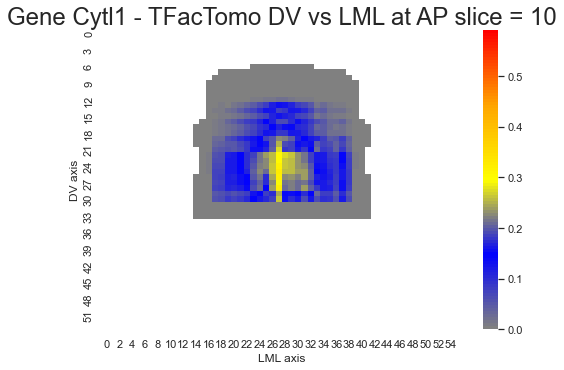

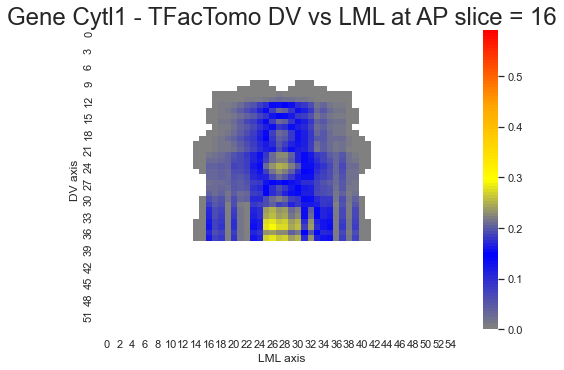

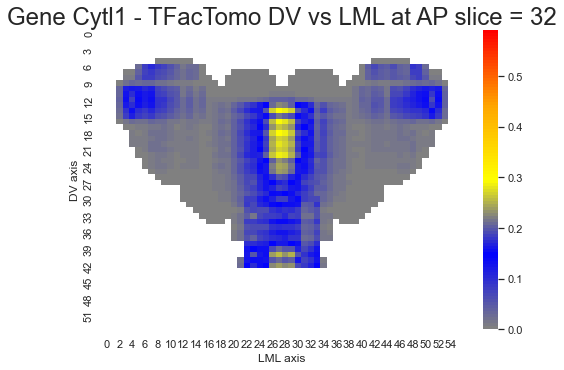

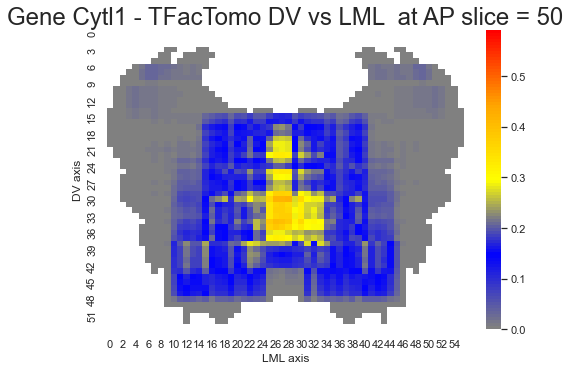

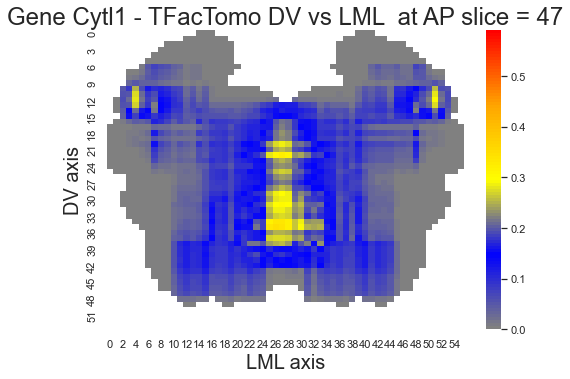

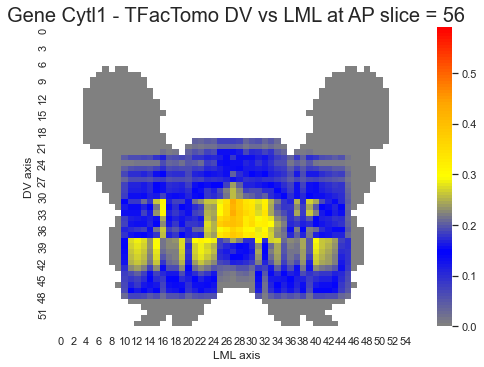

In [610]:
# mayras data

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.colors import LinearSegmentedColormap
r_palette = LinearSegmentedColormap.from_list(
    "R_palette", ["grey", "blue", "yellow", "orange", "red"], N=100
)

#M = mask3d

'''proj_3d_tfactomo = T_TFacTomo # Add +1 to avoid log(0)
proj_scaled = proj_3d_tfactomo * (av_gene_counts / proj_3d_tfactomo.sum())
proj_3d     = np.log10(proj_scaled + 1)'''

slice_idx = 10 # e.g. AP slice

pa_slice     = proj_tfactomo_mayra[:, :, slice_idx]
mask_slice   = mask3d[:,:, slice_idx]
mask_overlay = np.where(mask_slice==0, 1, np.nan)

plt.figure(figsize=(8,5.5))
sns.heatmap(pa_slice, cmap=r_palette, vmin=proj_tfactomo_mayra.min(), vmax=proj_tfactomo_mayra.max())
#plt.gca().invert_yaxis()
sns.heatmap(mask_overlay, cmap=white_cmap, cbar=None)
plt.title(f"Gene {gene_name} - TFacTomo DV vs LML at AP slice = {slice_idx}", fontsize=24)
plt.xlabel("LML axis")
plt.ylabel("DV axis")
plt.show()

slice_idx = 16 # e.g. AP slice

pa_slice     = proj_tfactomo_mayra[:, :, slice_idx]
mask_slice   = mask3d[:,:, slice_idx]
mask_overlay = np.where(mask_slice==0, 1, np.nan)

plt.figure(figsize=(8,5.5))
sns.heatmap(pa_slice, cmap=r_palette, vmin=proj_tfactomo_mayra.min(), vmax=proj_tfactomo_mayra.max())
#plt.gca().invert_yaxis()
sns.heatmap(mask_overlay, cmap=white_cmap, cbar=None)
plt.title(f"Gene {gene_name} - TFacTomo DV vs LML at AP slice = {slice_idx}", fontsize=24)
plt.xlabel("LML axis")
plt.ylabel("DV axis")
plt.show()


slice_idx = 32  # e.g. AP slice

pa_slice     = proj_tfactomo_mayra[:, :, slice_idx]
mask_slice   = mask3d[:,:, slice_idx]
mask_overlay = np.where(mask_slice==0, 1, np.nan)

plt.figure(figsize=(8,5.5))
sns.heatmap(pa_slice, cmap=r_palette, vmin=proj_tfactomo_mayra.min(), vmax=proj_tfactomo_mayra.max())
#plt.gca().invert_yaxis()
sns.heatmap(mask_overlay, cmap=white_cmap, cbar=None)
plt.title(f"Gene {gene_name} - TFacTomo DV vs LML at AP slice = {slice_idx}", fontsize=24)
plt.xlabel("LML axis")
plt.ylabel("DV axis")
plt.show()


slice_idx = 50 # e.g. AP slice

pa_slice     = proj_tfactomo_mayra[:, :, slice_idx]
mask_slice   = mask3d[:,:, slice_idx]
mask_overlay = np.where(mask_slice==0, 1, np.nan)

plt.figure(figsize=(8,5.5))
sns.heatmap(pa_slice, cmap=r_palette, vmin=proj_tfactomo_mayra.min(), vmax=proj_tfactomo_mayra.max())
#plt.gca().invert_yaxis()
sns.heatmap(mask_overlay, cmap=white_cmap, cbar=None)
plt.title(f"Gene {gene_name} - TFacTomo DV vs LML  at AP slice = {slice_idx}", fontsize=24)
plt.xlabel("LML axis")
plt.ylabel("DV axis")
plt.show()

slice_idx = 47 # e.g. AP slice

pa_slice     = proj_tfactomo_mayra[:, :, slice_idx]
mask_slice   = mask3d[:,:, slice_idx]
mask_overlay = np.where(mask_slice==0, 1, np.nan)

plt.figure(figsize=(8,5.5))
sns.heatmap(pa_slice, cmap=r_palette, vmin=proj_tfactomo_mayra.min(), vmax=proj_tfactomo_mayra.max())
#plt.gca().invert_yaxis()
sns.heatmap(mask_overlay, cmap=white_cmap, cbar=None)
plt.title(f"Gene {gene_name} - TFacTomo DV vs LML  at AP slice = {slice_idx}", fontsize=24)
plt.xlabel("LML axis", fontsize=20)
plt.ylabel("DV axis", fontsize=20)
plt.show()

white_cmap = ListedColormap(["white"])
slice_idx = 56 # e.g. AP slice

pa_slice     = proj_tfactomo_mayra[:, :, slice_idx]
mask_slice   = mask3d[:,:, slice_idx]
mask_overlay = np.where(mask_slice==0, 1, np.nan)

plt.figure(figsize=(8,5.5))
sns.heatmap(pa_slice, cmap=r_palette, vmin=proj_tfactomo_mayra.min(),vmax=proj_tfactomo_mayra.max())
#plt.gca().invert_yaxis()
sns.heatmap(mask_overlay, cmap=white_cmap, cbar=None)
plt.title(f"Gene {gene_name} - TFacTomo DV vs LML at AP slice = {slice_idx}", fontsize=20)
plt.xlabel("LML axis")
plt.ylabel("DV axis")
plt.show()


Evaluation TFacTomo using mayras data as input


In [376]:
def evaluation_metrics(pred, true):
    mse = np.mean((pred - true)**2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(pred - true))
    corr = np.corrcoef(pred, true)[0,1]
    nrmse = rmse / (np.max(true) - np.min(true))  # or use np.mean(true)
    
    return {'mse': mse, 'rmse': rmse, 'nrmse': nrmse, 'mae': mae, 'corr': corr}



In [477]:
tfactomo_mayra_sum_x

array([2.3802563e-08, 6.9608561e-08, 2.4928272e-07, 4.0689507e-08,
       1.3412707e-06, 7.6425038e-03, 8.3604014e-01, 7.2605550e-01,
       7.5616086e-01, 5.2551103e-01, 2.7002363e+00, 3.1410470e+00,
       3.8899717e+00, 6.3377352e+00, 7.2262869e+00, 5.7769318e+00,
       6.6348329e+00, 5.7080798e+00, 6.4435601e+00, 7.0632157e+00,
       8.2659035e+00, 8.0714140e+00, 1.0000458e+01, 9.4019737e+00,
       9.1639147e+00, 1.0302565e+01, 9.7576256e+00, 8.3520908e+00,
       9.6223087e+00, 9.1012974e+00, 1.0675873e+01, 8.0584879e+00,
       7.8051062e+00, 7.7671509e+00, 8.7590981e+00, 8.3948803e+00,
       7.4549847e+00, 7.8307986e+00, 7.0529485e+00, 6.0553722e+00,
       6.7592182e+00, 6.0755949e+00, 6.0868158e+00, 3.2182817e+00,
       2.5207052e+00, 2.2760375e+00, 2.0380387e+00, 1.8009965e+00,
       6.3055480e-01, 3.3085162e-05, 1.0450095e-06, 1.1513434e-06,
       1.0820510e-07, 2.3889854e-08], dtype=float32)

In [377]:
# accessing the values from the marginals

g_idx = np.where(genes == gene_name)[0][0]

target_DV_gene = target_DV[g_idx]
target_LML_gene = target_LML[g_idx]
target_AP_gene = target_AP[g_idx]


In [478]:
# Evaluation of tfactomo_mayra by authors

# tfactomo_mayra Reconstruction
tfactomo_mayra_sum_x = vol3d_mayra.sum(axis=(1, 2))
tfactomo_mayra_sum_y = vol3d_mayra.sum(axis=(0, 2))
tfactomo_mayra_sum_z = vol3d_mayra.sum(axis=(0, 1))


# normalized data:
tfactomo_mayra_sum_x_norm = tfactomo_mayra_sum_x/ tfactomo_mayra_sum_x.max()
tfactomo_mayra_sum_y_norm = tfactomo_mayra_sum_y/ tfactomo_mayra_sum_y.max()
tfactomo_mayra_sum_z_norm = tfactomo_mayra_sum_z/ tfactomo_mayra_sum_z.max()

target_DV_gene_norm = target_DV_gene/target_DV_gene.max()
target_LML_gene_norm = target_LML_gene/target_LML_gene.max()
target_AP_gene_norm = target_AP_gene/target_AP_gene.max()


print('Mayras preprocessing:')
# DV-axis

print('dv:', evaluation_metrics(tfactomo_mayra_sum_x_norm, target_DV_gene_norm))

# LML-axis
print('lml:', evaluation_metrics(tfactomo_mayra_sum_y_norm, target_LML_gene_norm))

# AP-axis
print('ap:', evaluation_metrics(tfactomo_mayra_sum_z_norm, target_AP_gene_norm))


Mayras preprocessing:
dv: {'mse': 0.020000727476298462, 'rmse': 0.14142392823104039, 'nrmse': 0.14142392823104039, 'mae': 0.11419130002666804, 'corr': 0.9643624276687012}
lml: {'mse': 0.00493955631791443, 'rmse': 0.07028197719127166, 'nrmse': 0.07028197719127166, 'mae': 0.055492214866979396, 'corr': 0.9802338455063941}
ap: {'mse': 0.019052267180481842, 'rmse': 0.13802995030239576, 'nrmse': 0.14673792559559437, 'mae': 0.10898493582259793, 'corr': 0.9334137998060854}


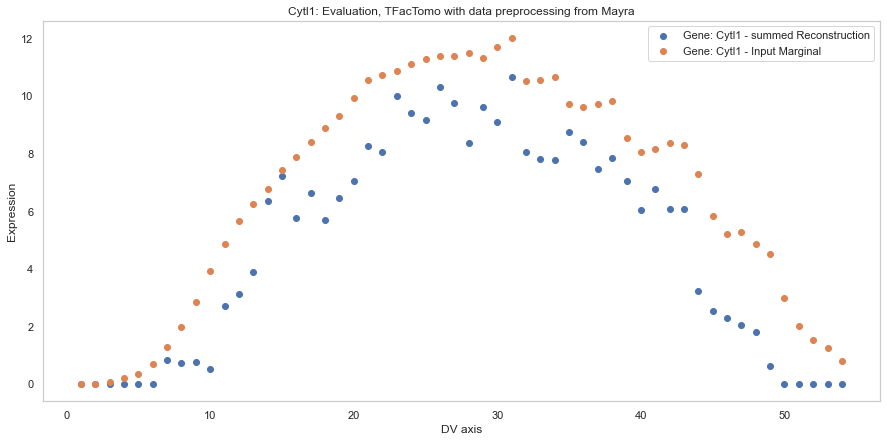

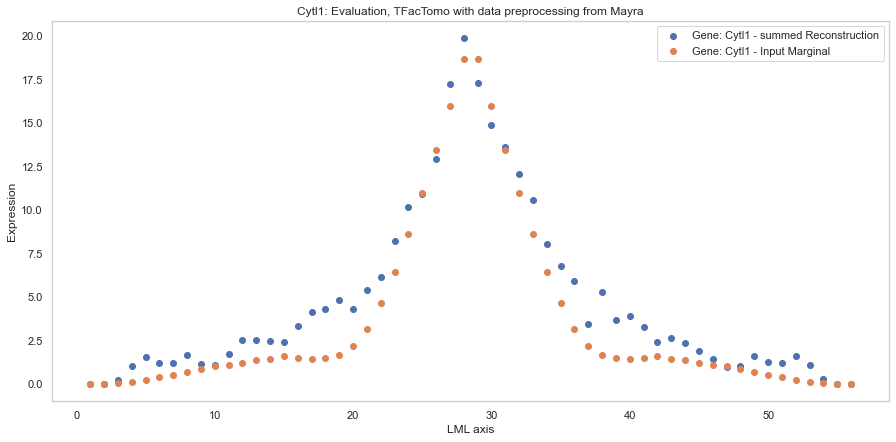

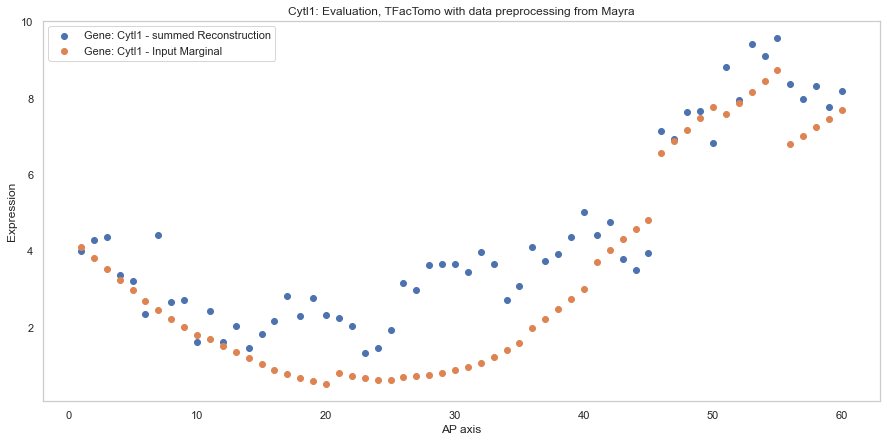

In [475]:
dv_slices = np.arange(1, len(target_DV_gene)+1)
ap_slices = np.arange(1, len(target_AP_gene)+1)
lml_slices = np.arange(1, len(target_LML_gene)+1)

plt.figure(figsize=(15,7))
plt.scatter(x=dv_slices,y=tfactomo_mayra_sum_x, label="Gene: Cytl1 - summed Reconstruction")
plt.scatter(x=dv_slices, y=target_DV_gene,  label="Gene: Cytl1 - Input Marginal")
plt.title("Cytl1: Evaluation, TFacTomo with data preprocessing from Mayra")
plt.xlabel("DV axis")
plt.ylabel("Expression")
plt.legend()
plt.grid()
plt.show()



plt.figure(figsize=(15,7))
plt.scatter(x=lml_slices,y=tfactomo_mayra_sum_y, label="Gene: Cytl1 - summed Reconstruction")
plt.scatter(x=lml_slices, y=target_LML_gene,  label="Gene: Cytl1 - Input Marginal")
plt.title("Cytl1: Evaluation, TFacTomo with data preprocessing from Mayra")
plt.xlabel("LML axis")
plt.ylabel("Expression")
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(15,7))
plt.scatter(x=ap_slices,y=tfactomo_mayra_sum_z, label="Gene: Cytl1 - summed Reconstruction")
plt.scatter(x=ap_slices, y=target_AP_gene,  label="Gene: Cytl1 - Input Marginal")
plt.title("Cytl1: Evaluation, TFacTomo with data preprocessing from Mayra")
plt.xlabel("AP axis")
plt.ylabel("Expression")
plt.legend()
plt.grid()
plt.show()

tfactomo preprocessing

In [603]:
# tfactomo preprocessing

# ---------------------------------- tfactomo data ---------------------------------- #

tl.set_backend('numpy')

# normalize by total expression

factors = [a.cpu().numpy() for a in A_ap1] # factors of the tensor --> 
full4d  = cp_to_tensor((None, factors))   # shape (n_genes, n_y, n_x, n_z)


# select one specific gene, here Cytl1 for visualization
gene_name = "Cytl1"

g_idx    = np.where(genes==gene_name)[0][0]

#mask3d = M.cpu().numpy() 

vol3d = full4d[g_idx]     # shape (n_y, n_x, n_z)


vol3d_sum = vol3d.sum()



total_dv_norm = DV_axis_norm.loc[gene_name].sum()
total_ap_norm = PA_axis_norm.loc[gene_name].sum()
total_lml_norm = LML_axis_norm.loc[gene_name].sum()

av_gene_counts = np.mean([total_dv_norm, total_ap_norm, total_lml_norm])
vol3d_scaled = vol3d * (av_gene_counts / vol3d_sum)


proj_tfactomo = np.log10(vol3d + 1)

proj_tfactomo *= mask3d



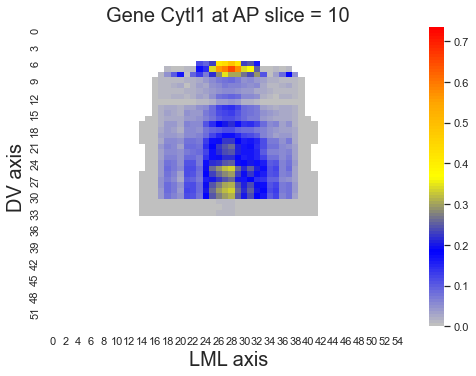

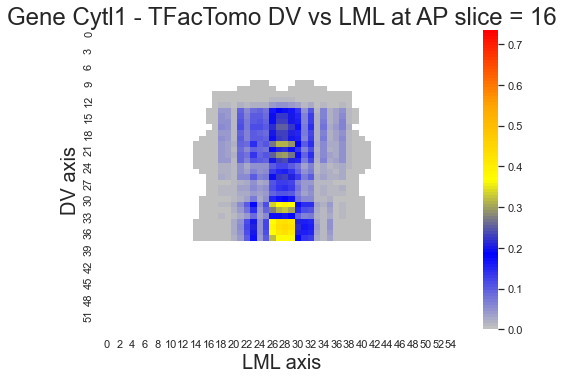

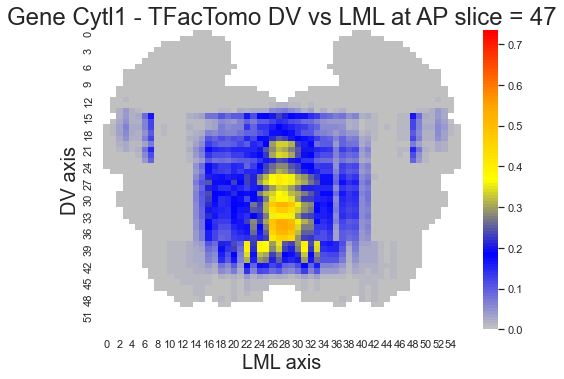

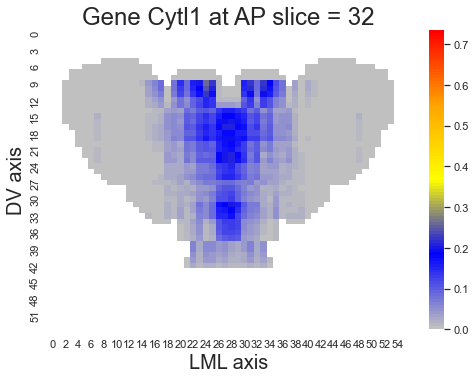

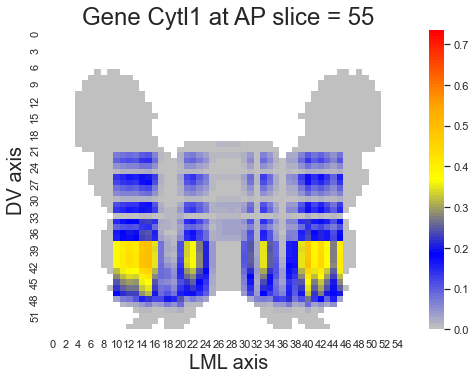

In [608]:

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.colors import LinearSegmentedColormap
r_palette = LinearSegmentedColormap.from_list(
    "R_palette", ["silver", "blue", "yellow", "orange", "red"], N=100
)

#M = mask3d

'''proj_3d_tfactomo = T_TFacTomo # Add +1 to avoid log(0)
proj_scaled = proj_3d_tfactomo * (av_gene_counts / proj_3d_tfactomo.sum())
proj_3d     = np.log10(proj_scaled + 1)'''


slice_idx = 10 # e.g. AP slice

pa_slice     = proj_tfactomo[:, :, slice_idx]
mask_slice   = mask3d[:,:, slice_idx]
mask_overlay = np.where(mask_slice==0, 1, np.nan)

plt.figure(figsize=(8,5.5))
sns.heatmap(pa_slice, cmap=r_palette, vmin=proj_tfactomo.min(), vmax=proj_tfactomo.max())
#plt.gca().invert_yaxis()
sns.heatmap(mask_overlay, cmap=white_cmap, cbar=None)
plt.title(f"Gene {gene_name} at AP slice = {slice_idx}", fontsize=20)
plt.xlabel("LML axis", fontsize=20)
plt.ylabel("DV axis", fontsize=20)
plt.show()


slice_idx = 16  # e.g. AP slice

pa_slice     = proj_tfactomo[:, :, slice_idx]
mask_slice   = mask3d[:,:, slice_idx]
mask_overlay = np.where(mask_slice==0, 1, np.nan)

plt.figure(figsize=(8,5.5))
sns.heatmap(pa_slice, cmap=r_palette, vmin=proj_tfactomo.min(), vmax=proj_tfactomo.max())
#plt.gca().invert_yaxis()
sns.heatmap(mask_overlay, cmap=white_cmap, cbar=None)
plt.title(f"Gene {gene_name} - TFacTomo DV vs LML at AP slice = {slice_idx}", fontsize=24)
plt.xlabel("LML axis", fontsize=20)
plt.ylabel("DV axis", fontsize=20)
plt.show()


slice_idx = 47 # e.g. AP slice

pa_slice     = proj_tfactomo[:, :, slice_idx]
mask_slice   = mask3d[:,:, slice_idx]
mask_overlay = np.where(mask_slice==0, 1, np.nan)

plt.figure(figsize=(8,5.5))
sns.heatmap(pa_slice, cmap=r_palette, vmin=proj_tfactomo.min(), vmax=proj_tfactomo.max())
#plt.gca().invert_yaxis()
sns.heatmap(mask_overlay, cmap=white_cmap, cbar=None)
plt.title(f"Gene {gene_name} - TFacTomo DV vs LML at AP slice = {slice_idx}", fontsize=24)
plt.xlabel("LML axis", fontsize=20)
plt.ylabel("DV axis", fontsize=20)
plt.show()

slice_idx = 32 # e.g. AP slice

pa_slice     = proj_tfactomo[:, :, slice_idx]
mask_slice   = mask3d[:,:, slice_idx]
mask_overlay = np.where(mask_slice==0, 1, np.nan)

plt.figure(figsize=(8,5.5))
sns.heatmap(pa_slice, cmap=r_palette, vmin=proj_tfactomo.min(), vmax=proj_tfactomo.max())
#plt.gca().invert_yaxis()
sns.heatmap(mask_overlay, cmap=white_cmap, cbar=None)
plt.title(f"Gene {gene_name} at AP slice = {slice_idx}", fontsize=24)
plt.xlabel("LML axis", fontsize=20)
plt.ylabel("DV axis", fontsize=20)
plt.show()

white_cmap = ListedColormap(["white"])
slice_idx = 55 # e.g. AP slice

pa_slice     = proj_tfactomo[:, :, slice_idx]
mask_slice   = mask3d[:,:, slice_idx]
mask_overlay = np.where(mask_slice==0, 1, np.nan)

plt.figure(figsize=(8,5.5))
sns.heatmap(pa_slice, cmap=r_palette, vmin=proj_tfactomo.min(), vmax=proj_tfactomo.max())
#plt.gca().invert_yaxis()
sns.heatmap(mask_overlay, cmap=white_cmap, cbar=None)
plt.title(f"Gene {gene_name} at AP slice = {slice_idx}", fontsize=24)
plt.xlabel("LML axis", fontsize=20)
plt.ylabel("DV axis", fontsize=20)
plt.show()


Evaluation TFacTomo results from authors

In [364]:
X_x_np # X_x_lml
X_y_np #  X_y_dv
X_z_np # X_z_ap

X_x_dataframe.shape

(9254, 56)

In [365]:
X_lml_gene = X_x_dataframe.loc[gene_name].values  #lml
X_dv_gene = X_y_dataframe.loc[gene_name].values #dv
X_ap_gene = X_z_dataframe.loc[gene_name].values #ap

In [479]:
# Evaluation of Tfactomo by authors


# tfactomo Reconstruction
tfactomo_sum_x = vol3d.sum(axis=(1, 2))
tfactomo_sum_y = vol3d.sum(axis=(0, 2))
tfactomo_sum_z = vol3d.sum(axis=(0, 1))

print('TFactomo authors preprocessing:')
# DV-axis
# normalized data:
tfactomo_sum_x_norm = tfactomo_sum_x/ tfactomo_sum_x.max()
tfactomo_sum_y_norm = tfactomo_sum_y/ tfactomo_sum_y.max()
tfactomo_sum_z_norm = tfactomo_sum_z/ tfactomo_sum_z.max()

X_dv_gene_norm = X_dv_gene/X_dv_gene.max()
X_lml_gene_norm = X_lml_gene/X_lml_gene.max()
X_ap_gene_norm = X_ap_gene/X_ap_gene.max()



print('dv:', evaluation_metrics(tfactomo_sum_x_norm, X_dv_gene_norm))

# LML-axis
print('lml:', evaluation_metrics(tfactomo_sum_y_norm, X_lml_gene_norm))

# AP-axis
print('ap:', evaluation_metrics(tfactomo_sum_z_norm, X_ap_gene_norm))


TFactomo authors preprocessing:
dv: {'mse': 0.022408342, 'rmse': 0.14969416, 'nrmse': 0.14969416, 'mae': 0.122957736, 'corr': 0.945073751078535}
lml: {'mse': 0.003854124, 'rmse': 0.062081594, 'nrmse': 0.062081594, 'mae': 0.04533891, 'corr': 0.9766333706046094}
ap: {'mse': 0.012219498, 'rmse': 0.110541835, 'nrmse': 0.119241536, 'mae': 0.089494914, 'corr': 0.9642439666939133}


In [468]:
print('marginal mayra:',X_dv_gene)
print('marginal tfactomo authors:',target_DV_gene)

marginal mayra: [  0.           0.50723785   2.0818613    6.0967197   11.237761
  22.563637    41.980534    64.81583     95.370125   132.7645
 165.82542    194.88876    217.79634    238.49129    264.8134
 283.31018    304.86862    326.31638    344.9627     370.71317
 397.06247    406.58783    415.47675    427.31543    437.23993
 443.28674    445.12363    452.38696    446.42743    462.7653
 476.99762    419.10687    421.41867    425.71725    388.5509
 385.60965    390.30444    394.9586     343.78564    325.27356
 330.4115     338.7655     337.0924     296.43253    238.05453
 212.56648    215.85016    199.12782    185.10606    123.15891
  83.27643     63.304127    51.294453    33.64654   ]
marginal tfactomo authors: [ 0.          0.01681726  0.06794695  0.1958863   0.35553554  0.70309912
  1.29039494  1.96803331  2.86113421  3.93627394  4.86004439  5.64774828
  6.24248573  6.76273619  7.43126824  7.87006393  8.38779187  8.89511925
  9.32025337  9.93135273 10.55172889 10.72260872 10.87848

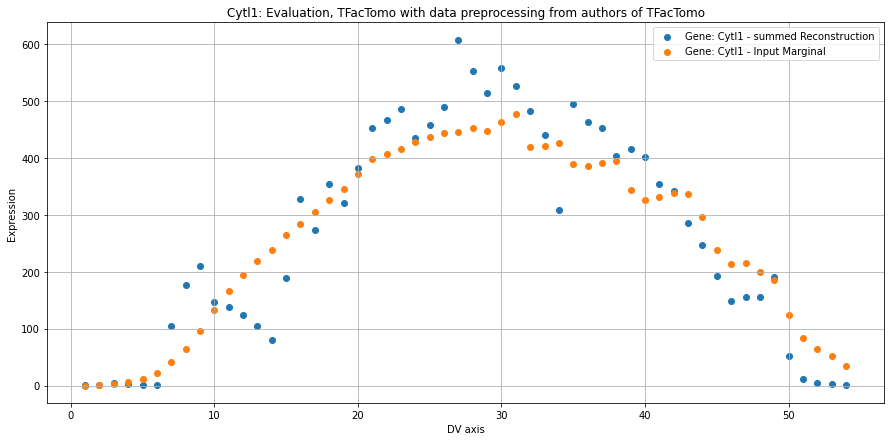

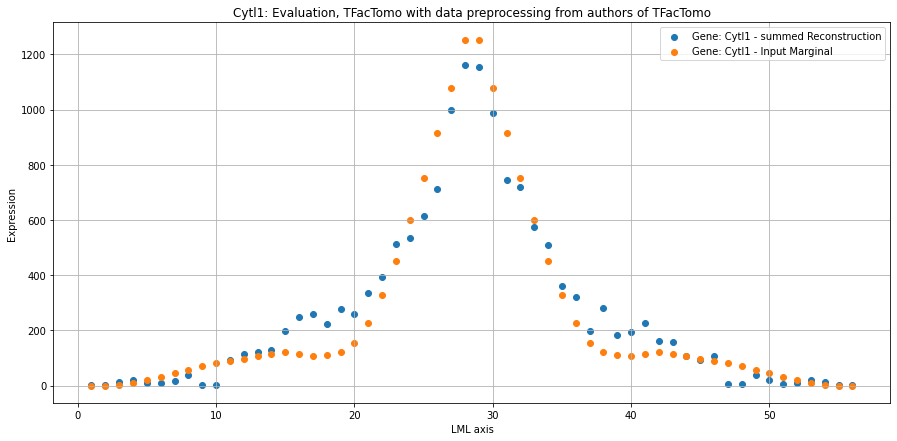

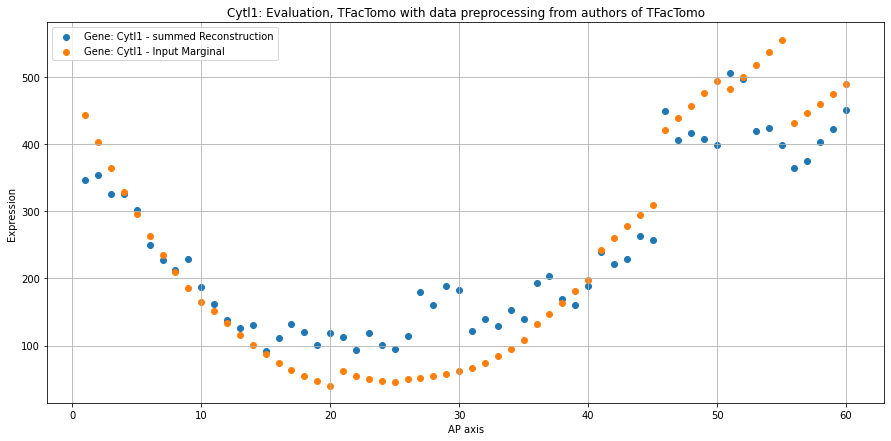

In [387]:
dv_slices = np.arange(1, len(X_dv_gene)+1)
ap_slices = np.arange(1, len(X_ap_gene)+1)
lml_slices = np.arange(1, len(X_lml_gene)+1)

plt.figure(figsize=(15,7))
plt.scatter(x=dv_slices,y=tfactomo_sum_x, label="Gene: Cytl1 - summed Reconstruction")
plt.scatter(x=dv_slices, y=X_dv_gene,  label="Gene: Cytl1 - Input Marginal")
plt.title("Cytl1: Evaluation, TFacTomo with data preprocessing from authors of TFacTomo")
plt.xlabel("DV axis")
plt.ylabel("Expression")
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(15,7))
plt.scatter(x=lml_slices,y=tfactomo_sum_y, label="Gene: Cytl1 - summed Reconstruction")
plt.scatter(x=lml_slices, y=X_lml_gene,  label="Gene: Cytl1 - Input Marginal")
plt.title("Cytl1: Evaluation, TFacTomo with data preprocessing from authors of TFacTomo")
plt.xlabel("LML axis")
plt.ylabel("Expression")
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(15,7))
plt.scatter(x=ap_slices,y=tfactomo_sum_z, label="Gene: Cytl1 - summed Reconstruction")
plt.scatter(x=ap_slices, y=X_ap_gene,  label="Gene: Cytl1 - Input Marginal")
plt.title("Cytl1: Evaluation, TFacTomo with data preprocessing from authors of TFacTomo")
plt.xlabel("AP axis")
plt.ylabel("Expression")
plt.legend()
plt.grid()
plt.show()

In [401]:
df

,axis,preprocessing,metric,value
0,DV,TFactoMo authors,MAE,53.497980
1,DV,Mayra,MAE,1.910810
2,DV,TFactoMo authors,NRMSE,0.138196
3,DV,Mayra,NRMSE,0.181080
4,DV,TFactoMo authors,CORR,0.945074
5,DV,Mayra,CORR,0.964360
6,LML,TFactoMo authors,MAE,58.508000
7,LML,Mayra,MAE,1.169800
8,LML,TFactoMo authors,NRMSE,0.061848
9,LML,Mayra,NRMSE,0.078090


In [ ]:
ipf_metrics = {
'dv': {'mse': 4.801852143761217e-13, 'rmse': 6.929539770981344e-07, 'nrmse': 6.929539770981344e-07, 'mae': 5.539540270528521e-07, 'corr': 0.9999999999979574},
'lml': {'mse': 2.982521265490498e-15, 'rmse': 5.461246437847772e-08, 'nrmse': 5.461246437847772e-08, 'mae': 4.571589178719108e-08, 'corr': 0.9999999999999937},
'ap': {'mse': 9.069693615313692e-31, 'rmse': 9.523493904714642e-16, 'nrmse': 1.0124308071824742e-15, 'mae': 5.857582937215019e-16, 'corr': 0.9999999999999998}}

ipf_metrics_df = pd.DataFrame(ipf_metrics)


# pp 1: TFacTomo authors

tfactomo_authors_metrics = {
'dv': {'mse': 0.022408342, 'rmse': 0.14969416, 'nrmse': 0.14969416, 'mae': 0.122957736, 'corr': 0.945073751078535},
'lml': {'mse': 0.003854124, 'rmse': 0.062081594, 'nrmse': 0.062081594, 'mae': 0.04533891, 'corr': 0.9766333706046094},
'ap': {'mse': 0.012219498, 'rmse': 0.110541835, 'nrmse': 0.119241536, 'mae': 0.089494914, 'corr': 0.9642439666939133}}

tfactomo_authors_metrics_df = pd.DataFrame(tfactomo_authors_metrics)

# pp 2: Mayra
tfactomo_mayra_metrics = {
'dv': {'mse': 0.020000727476298462, 'rmse': 0.14142392823104039, 'nrmse': 0.14142392823104039, 'mae': 0.11419130002666804, 'corr': 0.9643624276687012},
'lml': {'mse': 0.00493955631791443, 'rmse': 0.07028197719127166, 'nrmse': 0.07028197719127166, 'mae': 0.055492214866979396, 'corr': 0.9802338455063941},
'ap': {'mse': 0.019052267180481842, 'rmse': 0.13802995030239576, 'nrmse': 0.14673792559559437, 'mae': 0.10898493582259793, 'corr': 0.9334137998060854}}

tfactomo_mayra_metrics_df = pd.DataFrame(tfactomo_mayra_metrics)



df_metrics = pd.concat([ipf_metrics_df,tfactomo_authors_metrics_df,tfactomo_mayra_metrics_df])


# MAE
metrics_mae = {
'ipf': {'DV':  3.7007764705250303,'LML': 3.3915753638971213,'AP': 3.2672630066705577},
'tfactomo pp 1': {'DV': 0.945073751078535,'LML':0.04533891,'AP': 0.089494914},
'tfactomo pp 2': {'DV': 0.11419130002666804,'LML': 0.055492214866979396,'AP': 0.10898493582259793}}

metrics_mae_df = pd.DataFrame(metrics_mae)

# CORR
metrics_corr = {
'ipf': {'DV':  0.9999999999998934,'LML':0.9999999999999858,'AP': 1.0},
'tfactomo pp 1': {'DV': 0.945073751078535,'LML':0.9766333706046094,'AP': 0.9642439666939133},
'tfactomo pp 2': {'DV': 0.9643624276687012,'LML': 0.9802338455063941,'AP':0.9334137998060854}}

metrics_corr_df = pd.DataFrame(metrics_corr)

# MSE
metrics_mse = {
'ipf': {'DV':  25.1386581405306,'LML': 15.146550375173343,'AP': 18.222252536962618},
'tfactomo pp 1': {'DV': 0.022408342,'LML':0.003854124,'AP': 0.012219498},
'tfactomo pp 2': {'DV':  0.020000727476298462,'LML':0.00493955631791443,'AP':0.019052267180481842}}

metrics_mse_df = pd.DataFrame(metrics_mse)


# change shape, so that it is more suitable for the barplot

df_melted_mae = metrics_mae_df.melt(id_vars='metric', var_name='method', value_name='value')

df_melted_corr = metrics_corr_df.melt(id_vars='metric', var_name='method', value_name='value')

df_melted_mse = metrics_mse_df.melt(id_vars='metric', var_name='method', value_name='value')



KeyError: 'metric'

In [513]:
metrics_mae_df = {
    'axis': ['DV', 'LML', 'AP'],
    'IPF': [3.7007764705250303, 3.3915753638971213,3.2672630066705577],
    'TFacTomo pp1': [0.945073751078535,0.04533891, 0.089494914],
    'TFacTomo pp2': [ 0.11419130002666804,0.055492214866979396,0.10898493582259793]
}

metrics_mse_df = {
    'axis': ['DV', 'LML', 'AP'],
    'IPF': [25.1386581405306,15.146550375173343, 18.222252536962618],
    'TFacTomo pp1': [0.022408342,0.003854124, 0.012219498],
    'TFacTomo pp2': [0.020000727476298462,0.00493955631791443,0.019052267180481842]
}

metrics_corr_df = {
    'axis': ['DV', 'LML', 'AP'],
    'IPF': [0.9999999999998934,0.9999999999999858, 1.0],
    'TFacTomo pp1': [0.945073751078535,0.9766333706046094,0.9642439666939133],
    'TFacTomo pp2': [0.9643624276687012,0.9802338455063941,0.9334137998060854]
}

metrics_corr_df = pd.DataFrame(metrics_corr_df)

metrics_mse_df = pd.DataFrame(metrics_mse_df)

metrics_mae_df = pd.DataFrame(metrics_mae_df)


# only TFacTomo results


metrics_mae_tfac = {
    'axis': ['DV', 'LML', 'AP'],
    'TFacTomo pp1': [0.945073751078535,0.04533891, 0.089494914],
    'TFacTomo pp2': [ 0.11419130002666804,0.055492214866979396,0.10898493582259793]
}

metrics_mse_tfac = {
    'axis': ['DV', 'LML', 'AP'],
    'TFacTomo pp1': [0.022408342,0.003854124, 0.012219498],
    'TFacTomo pp2': [0.020000727476298462,0.00493955631791443,0.019052267180481842]
}


metrics_mse_tfactomo = pd.DataFrame(metrics_mse_tfac)

metrics_mae_tfactomo = pd.DataFrame(metrics_mae_tfac)

In [514]:
df_melted_mae = metrics_mae_df.melt(id_vars='axis', var_name='method', value_name='value')
df_melted_mse = metrics_mse_df.melt(id_vars='axis', var_name='method', value_name='value')
df_melted_corr = metrics_corr_df.melt(id_vars='axis', var_name='method', value_name='value')


tfactomo_mae = metrics_mae_tfactomo.melt(id_vars='axis', var_name='method', value_name='value')
tfactomo_mse = metrics_mse_tfactomo.melt(id_vars='axis', var_name='method', value_name='value')



In [498]:
df_melted_mae

,axis,method,value
0,DV,IPF,3.700776
1,LML,IPF,3.391575
2,AP,IPF,3.267263
3,DV,TFacTomo pp1,0.945074
4,LML,TFacTomo pp1,0.045339
5,AP,TFacTomo pp1,0.089495
6,DV,TFacTomo pp2,0.114191
7,LML,TFacTomo pp2,0.055492
8,AP,TFacTomo pp2,0.108985


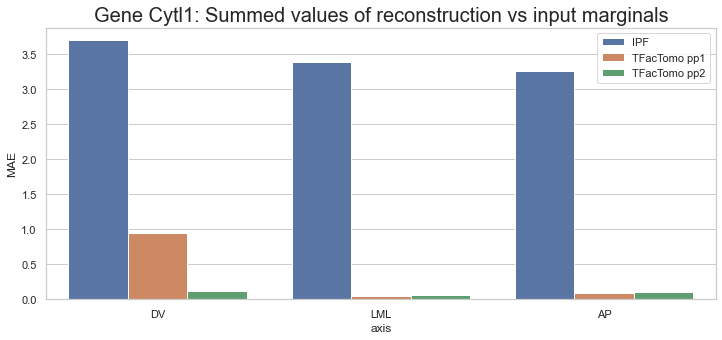

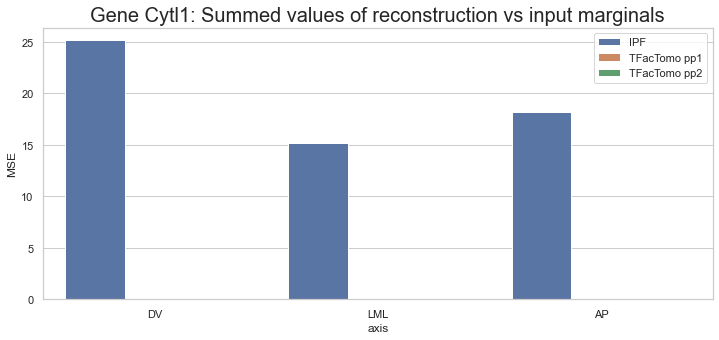

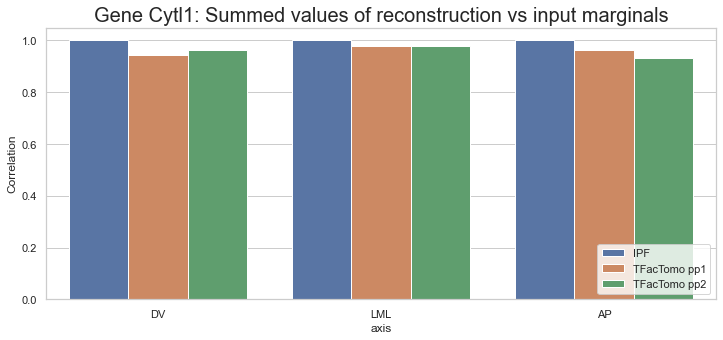

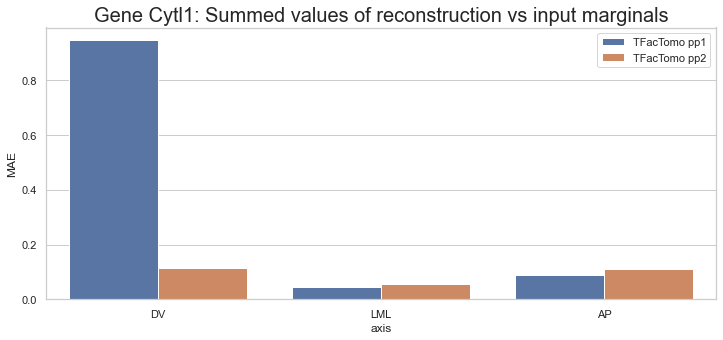

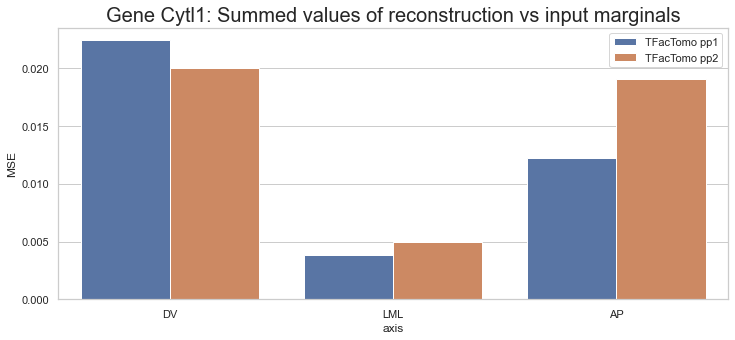

In [586]:
plt.figure(figsize=(12,5))

sns.barplot(df_melted_mae, x='axis', y='value', hue='method')
plt.title('Gene Cytl1: Summed values of reconstruction vs input marginals',fontsize=20)
plt.ylabel('MAE')
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
sns.barplot(df_melted_mse, x='axis', y='value', hue='method')
plt.title('Gene Cytl1: Summed values of reconstruction vs input marginals', fontsize=20)
plt.ylabel('MSE')
plt.legend()
plt.show()

plt.figure(figsize=(12,5))

sns.barplot(df_melted_corr, x='axis', y='value', hue='method')
plt.title('Gene Cytl1: Summed values of reconstruction vs input marginals',fontsize=20)
plt.ylabel('Correlation')
plt.legend(loc='lower right')
plt.show()


# only TFacTOmo

plt.figure(figsize=(12,5))
sns.barplot(tfactomo_mae, x='axis', y='value', hue='method')
plt.title('Gene Cytl1: Summed values of reconstruction vs input marginals', fontsize=20)
plt.ylabel('MAE')
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
sns.barplot(tfactomo_mse, x='axis', y='value', hue='method')
plt.title('Gene Cytl1: Summed values of reconstruction vs input marginals', fontsize=20)
plt.ylabel('MSE')
plt.legend()
plt.show()
